In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import xdem
import geoutils as gu
import numpy as np
import datetime
import psutil
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import tools

## Experiment 2
- ASTER dems
- using processed outputs from ragmac_xdem/scripts/main_experiment2.py
- these dems are all already aligned, but can add check and reproject as needed, e.g. https://github.com/GlacioHack/geoprofile/blob/main/geoprofile/core/core.py#L122

In [3]:
input_dir = '../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs'
dems = glob.glob(os.path.join(input_dir, '*.tif'))

In [4]:
dems

['../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs/DEM_2013.38122053_coreg.tif',
 '../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs/DEM_2000.54825814_coreg.tif',
 '../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs/DEM_2000.69885137_coreg.tif',
 '../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs/DEM_2012.22515096_coreg.tif',
 '../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs/DEM_2012.31276225_coreg.tif',
 '../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs/DEM_2012.31276254_coreg.tif',
 '../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs/DEM_2012.46335551_coreg.tif',
 '../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs/DEM_2012.63857803_coreg.tif',
 '../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs/DEM_2012.74536543_coreg.tif',
 '../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs/DEM_2012.74536571_coreg.tif',
 '../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs/DEM_2013.55644295_coreg.tif',
 '../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs/DEM_2018.7

In [5]:
arrays = []
dt_list = []

for i in dems[:3]:
    src = gu.georaster.Raster(i)
    masked_array = src.data
    
    arrays.append(masked_array)
    
    date_time = float(os.path.basename(i).split('_')[1])
    dt_list.append(date_time)
    
ma_stack = np.vstack(arrays)

dt_list = [tools.convert_decimal_date_to_date_time(i)[0] for i in dt_list]

In [6]:
ma_stack.shape

(3, 3176, 3878)

In [7]:
dt_list

[datetime.datetime(2013, 5, 19, 5, 46, 45),
 datetime.datetime(2000, 7, 18, 6, 1, 51),
 datetime.datetime(2000, 9, 11, 6, 7, 52)]

### Temporal regression

github issue: https://github.com/adehecq/ragmac_xdem/issues/8

```
Write a function that takes a stack of DEMs on the same grid (i.e. a 3D masked array) and returns fit parameters of a temporal regression.
Example based on David's code: https://github.com/dshean/pygeotools/blob/9c8d7d5cff5f4fd1c08cf2d46dd1566d229ae9ad/pygeotools/lib/malib.py#L999

Additionally, write a function that takes the fit parameters and returns the elevation of all pixels at any given time within the valid time range.
```


In [8]:
%%time
"""
Modifications to malib.ma_linreg transposed to tools.py
# use matplitlib.dates.date2num directly to convert time stamps
# use psutils to check for logical cores
# add aux functions from malib.py 
 - mad()
 - checkma()
"""

results = tools.ma_linreg(ma_stack, 
                          dt_list, 
                          n_thresh=2, 
                          model='linear', 
                          dt_stack_ptp=None, 
                          min_dt_ptp=None, 
                          smooth=False,
                          rsq=False, 
                          conf_test=False, 
                          parallel=True, 
                          n_cpu=None, 
                          remove_outliers=False)

Excluding pixels with count < 2
12316528 valid pixels with up to 3 timestamps: 36949584 total valid samples
Solving for trend
Computing residuals
CPU times: user 6.22 s, sys: 1.52 s, total: 7.74 s
Wall time: 5.51 s


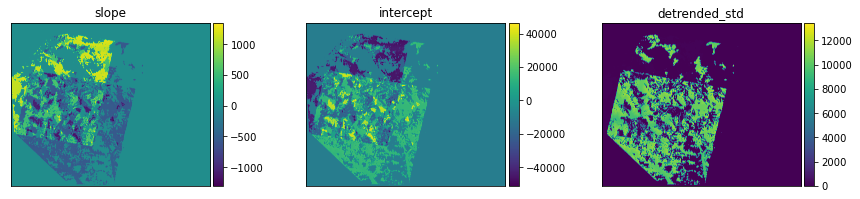

In [9]:
fig,axes = plt.subplots(1,3, figsize=(15,3))

for i,v in enumerate(['slope','intercept','detrended_std']):
    ax = axes[i]
    ax.set_title(label=v, size=12)
    ax.set_xticks(())
    ax.set_yticks(())
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(ax.imshow(results[i]),cax=cax)

<div class="alert alert-block alert-warning">
It appears the mask isn't properly set. All values are set to `False`.
</div>

In [10]:
for r in results:
    print(np.unique(r.mask))

[False]
[False]
[False]


<div class="alert alert-block alert-warning">
Replacing the nodata values with np.nan up front...  
</div>

In [11]:
arrays = []
dt_list = []

for i in dems[:3]:
    src = gu.georaster.Raster(i)
#     masked_array = src.data
    array = src.data.data
    mask = array == src.nodata
    masked_array = np.ma.masked_array(array, mask=mask)
    array = np.ma.filled(masked_array, fill_value=np.nan)
    masked_array = np.ma.masked_array(array, mask=mask)
    
    arrays.append(masked_array)
    
    date_time = float(os.path.basename(i).split('_')[1])
    dt_list.append(date_time)
    
ma_stack = np.vstack(arrays)

dt_list = [tools.convert_decimal_date_to_date_time(i)[0] for i in dt_list]

In [12]:
%%time
results = tools.ma_linreg(ma_stack, 
                          dt_list, 
                          n_thresh=2, 
                          model='linear', 
                          dt_stack_ptp=None, 
                          min_dt_ptp=None, 
                          smooth=False,
                          rsq=False, 
                          conf_test=False, 
                          parallel=True, 
                          n_cpu=None, 
                          remove_outliers=False)

Excluding pixels with count < 2
12316528 valid pixels with up to 3 timestamps: 36949584 total valid samples
Solving for trend
Computing residuals
CPU times: user 6.23 s, sys: 1.56 s, total: 7.79 s
Wall time: 5.56 s


<div class="alert alert-block alert-warning">
Replacing the nodata values up front leaves only few valid pixels.  
</div>

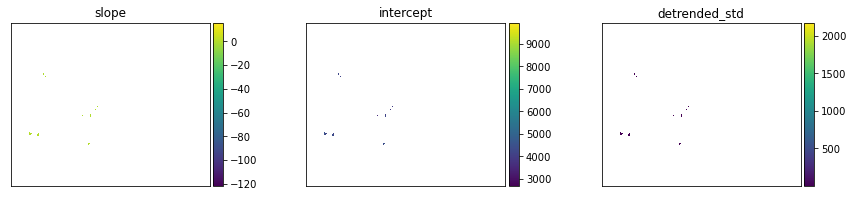

In [13]:
fig,axes = plt.subplots(1,3, figsize=(15,3))

for i,v in enumerate(['slope','intercept','detrended_std']):
    ax = axes[i]
    ax.set_title(label=v, size=12)
    ax.set_xticks(())
    ax.set_yticks(())
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(ax.imshow(results[i]),cax=cax)